<a href="https://colab.research.google.com/github/ReuelNixon/learn-pytorch/blob/main/02_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Network classification with PyTorch

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


### 1. Make classification data and get it ready

In [ ]:
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import matplotlib.pyplot as plt
from helper_functions import plot_decision_boundary

In [ ]:
X, y = make_circles(n_samples=2000, noise=0.03)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

X_train[:5], X_test[:5], y_test[:5], y_train[:5]

(tensor([[-0.8191,  0.0150],
         [-0.9651, -0.1358],
         [ 0.7640,  0.3022],
         [ 0.2213,  0.7704],
         [ 0.8853, -0.5022]]),
 tensor([[ 0.5677, -0.8268],
         [ 0.3294, -0.9785],
         [-0.8929, -0.4773],
         [ 0.1721, -0.8227],
         [ 0.7730, -0.6677]]),
 tensor([0., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 1., 0.]))

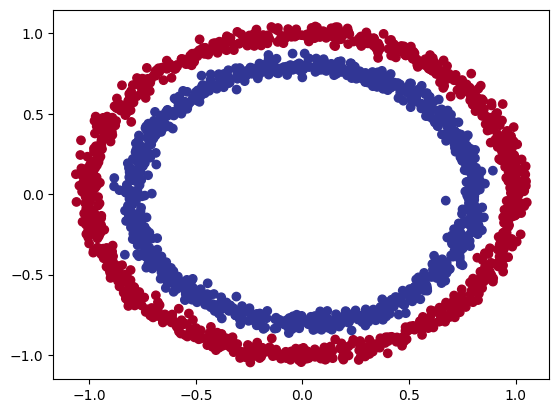

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c = y, cmap=plt.cm.RdYlBu);

In [ ]:
def accuracy_fn(y_pred, y_true):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 2. Building a model
Let's build a model to classify our blue and red dots.

To do so, we want to:

1. Setup device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [ ]:
class CircleModel(nn.Module):
  def __init__(self, in_features, out_features, intermediate_features):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=intermediate_features),
        nn.ReLU(),
        nn.Linear(in_features=intermediate_features, out_features=intermediate_features),
        nn.ReLU(),
        nn.Linear(in_features=intermediate_features, out_features=out_features)
    )

  def forward(self, x):
    return self.layer_stack(x)

model_0 = CircleModel(2, 1, 10).to(device)
model_0

CircleModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
epochs = 2000

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  train_logits = model_0(X_train).squeeze()
  train_preds = torch.round(torch.sigmoid(train_logits))

  loss = loss_fn(train_logits, y_train)
  acc = accuracy_fn(train_preds, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_preds, y_test)
    test_acc = accuracy_fn(test_preds, y_test)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} \t Train Loss: {loss:.5f} \t Train Accuracy: {acc:.2f} \t Test Loss: {test_loss:5f} \t Test accuracy: {test_acc:.2f}')

Epoch: 0 	 Train Loss: 0.69608 	 Train Accuracy: 45.69 	 Test Loss: 0.751989 	 Test accuracy: 50.00
Epoch: 100 	 Train Loss: 0.69356 	 Train Accuracy: 52.81 	 Test Loss: 0.791934 	 Test accuracy: 51.50
Epoch: 200 	 Train Loss: 0.69136 	 Train Accuracy: 52.31 	 Test Loss: 0.783638 	 Test accuracy: 54.00
Epoch: 300 	 Train Loss: 0.68954 	 Train Accuracy: 53.25 	 Test Loss: 0.783834 	 Test accuracy: 53.00
Epoch: 400 	 Train Loss: 0.68723 	 Train Accuracy: 54.50 	 Test Loss: 0.773331 	 Test accuracy: 54.50
Epoch: 500 	 Train Loss: 0.68443 	 Train Accuracy: 65.25 	 Test Loss: 0.699518 	 Test accuracy: 66.50
Epoch: 600 	 Train Loss: 0.68032 	 Train Accuracy: 72.25 	 Test Loss: 0.653610 	 Test accuracy: 74.00
Epoch: 700 	 Train Loss: 0.67380 	 Train Accuracy: 72.12 	 Test Loss: 0.657157 	 Test accuracy: 72.75
Epoch: 800 	 Train Loss: 0.66283 	 Train Accuracy: 72.06 	 Test Loss: 0.655956 	 Test accuracy: 72.75
Epoch: 900 	 Train Loss: 0.64259 	 Train Accuracy: 75.31 	 Test Loss: 0.633959 	 Tes

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 0.], device='cuda:0'),
 tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 0.], device='cuda:0'))

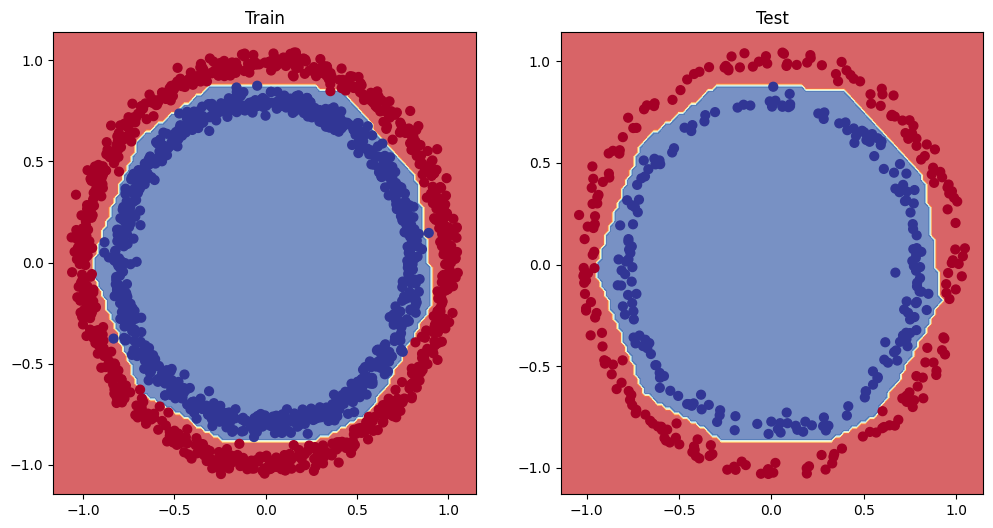

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Multi class classification problem

### 1. Creating a toy multi-class dataset

In [ ]:
X, y = make_blobs(n_samples = 2000, n_features=2, centers = 4, cluster_std = 1.3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.LongTensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.LongTensor).to(device)
X_train[:5], X_test[:5], y_train[:5], y_test[:5]

(tensor([[ 3.1918,  7.0846],
         [ 4.5193,  7.0114],
         [ 6.2399, -3.2331],
         [ 2.2109, -1.8055],
         [ 5.8939, -3.7575]], device='cuda:0'),
 tensor([[ 6.2331,  0.6046],
         [ 6.8292,  2.5662],
         [ 8.8316, -4.7054],
         [ 7.4589,  0.4201],
         [ 3.6374, -0.4429]], device='cuda:0'),
 tensor([0, 0, 3, 2, 3], device='cuda:0'),
 tensor([1, 1, 3, 1, 2], device='cuda:0'))

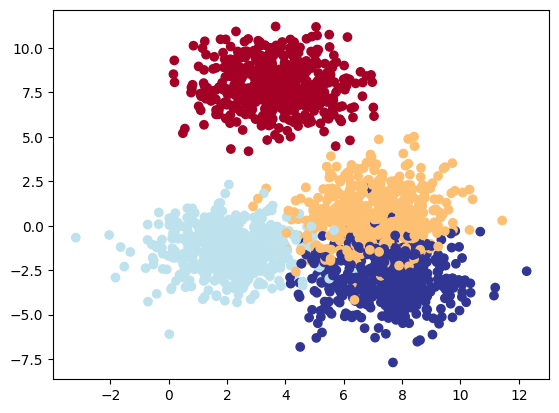

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c = y, cmap=plt.cm.RdYlBu);

### 2. Building a multi-class classification model


In [ ]:
class BlobModel(nn.Module):
  def __init__(self, in_features, out_features, intermediate_features):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=in_features, out_features=intermediate_features),
        nn.ReLU(),
        nn.Linear(in_features=intermediate_features, out_features=intermediate_features),
        nn.ReLU(),
        nn.Linear(in_features=intermediate_features, out_features=out_features)
    )

  def forward(self, x):
    return self.layer_stack(x)

model_1 = BlobModel(2, 4, 8).to(device)
model_1

BlobModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1)

In [ ]:
epochs = 2000

for epoch in range(epochs):
  model_1.train()

  train_logits = model_1(X_train).squeeze()
  train_preds = torch.softmax(train_logits, dim=1).argmax(dim = 1)

  loss = loss_fn(train_logits, y_train)
  acc = accuracy_fn(train_preds, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_preds, y_test)

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} \t Train Loss: {loss:.5f} \t Train Accuracy: {acc:.2f} \t Test Loss: {test_loss:5f} \t Test accuracy: {test_acc:.2f}')

Epoch: 0 	 Train Loss: 1.41362 	 Train Accuracy: 24.62 	 Test Loss: 1.317134 	 Test accuracy: 50.50
Epoch: 100 	 Train Loss: 0.42201 	 Train Accuracy: 83.81 	 Test Loss: 0.422031 	 Test accuracy: 83.75
Epoch: 200 	 Train Loss: 0.27430 	 Train Accuracy: 90.06 	 Test Loss: 0.236809 	 Test accuracy: 91.50
Epoch: 300 	 Train Loss: 0.19826 	 Train Accuracy: 93.12 	 Test Loss: 0.181008 	 Test accuracy: 93.75
Epoch: 400 	 Train Loss: 0.18184 	 Train Accuracy: 93.44 	 Test Loss: 0.164906 	 Test accuracy: 93.75
Epoch: 500 	 Train Loss: 0.18117 	 Train Accuracy: 93.25 	 Test Loss: 0.162288 	 Test accuracy: 94.00
Epoch: 600 	 Train Loss: 0.17515 	 Train Accuracy: 93.44 	 Test Loss: 0.156317 	 Test accuracy: 93.75
Epoch: 700 	 Train Loss: 0.17305 	 Train Accuracy: 93.50 	 Test Loss: 0.153763 	 Test accuracy: 94.00
Epoch: 800 	 Train Loss: 0.17163 	 Train Accuracy: 93.56 	 Test Loss: 0.152294 	 Test accuracy: 94.50
Epoch: 900 	 Train Loss: 0.16906 	 Train Accuracy: 93.69 	 Test Loss: 0.150045 	 Tes

In [ ]:
model_0.eval()
with torch.inference_mode():
  y_preds = torch.softmax(model_1(X_test), dim = 1).squeeze().argmax(dim = 1)
y_preds[:10], y_test[:10]

(tensor([1, 1, 3, 1, 2, 1, 3, 1, 0, 0], device='cuda:0'),
 tensor([1, 1, 3, 1, 2, 1, 3, 1, 0, 0], device='cuda:0'))

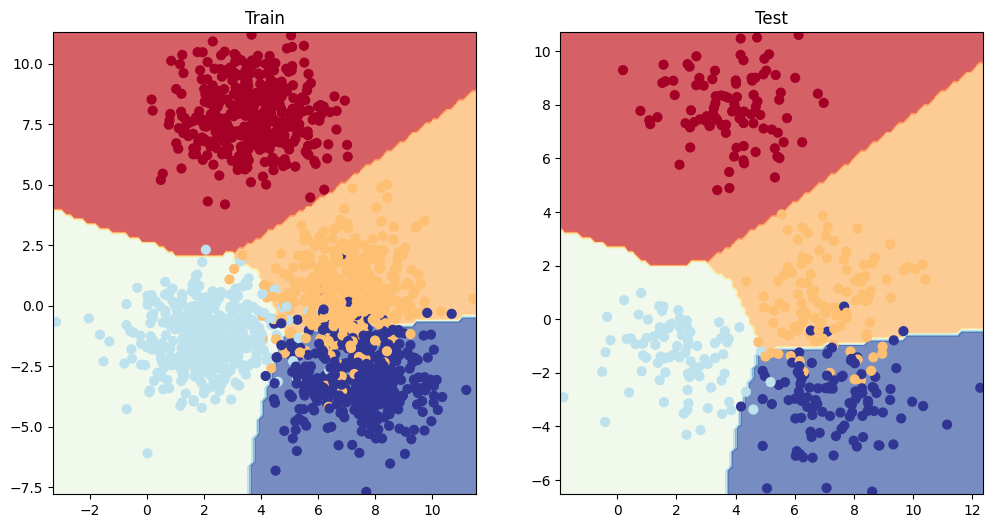

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)